In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "../src")

Let's try to apply the DLT again, but this time with some normalization.

- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:bali_3d_reconstruction_using_dlt.pdf
- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:ece4580_t03_calibration.pdf
- https://rpg.ifi.uzh.ch/docs/teaching/2020/03_camera_calibration.pdf

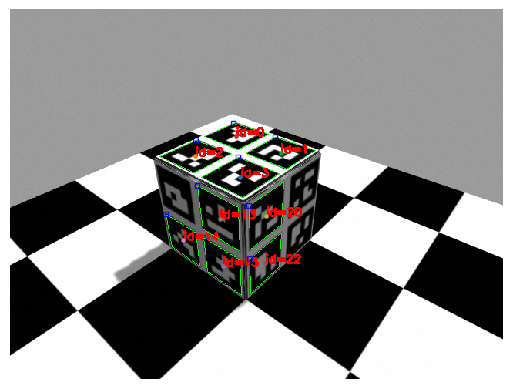

array([ 3,  2,  1,  0, 15, 22, 14, 13, 20], dtype=int32)

array([[ 0.05375,  0.05375,  0.2    ],
       [ 0.05375, -0.05125,  0.2    ],
       [-0.05125,  0.05375,  0.2    ],
       [-0.05125, -0.05125,  0.2    ],
       [ 0.1    , -0.05125,  0.04875],
       [ 0.05375,  0.1    ,  0.04875],
       [ 0.1    ,  0.05375,  0.04875],
       [ 0.1    , -0.05125,  0.15375],
       [ 0.05375,  0.1    ,  0.15375]])

array([[-3.45183e+03, -5.27140e+02, -3.57450e+02,  3.36860e+02],
       [-1.63784e+03, -2.12340e+02,  2.90300e+01,  1.41530e+02],
       [-1.05100e+01, -2.19000e+00, -7.40000e-01,  1.00000e+00]])

array([[298.75, 216.75],
       [240.25, 190.  ],
       [351.25, 185.75],
       [293.25, 164.25],
       [276.25, 333.  ],
       [331.  , 329.25],
       [224.75, 299.25],
       [271.75, 271.25],
       [332.  , 267.5 ]], dtype=float32)

array([[ 305.9 ,  284.49,    1.  ],
       [ 268.11,  176.12,    1.  ],
       [ 325.4 ,  172.84,    1.  ],
       [ 312.39,  161.2 ,    1.  ],
       [  50.85, -399.88,    1.  ],
       [ 452.26,  187.64,    1.  ],
       [ 263.46,  157.09,    1.  ],
       [ 681.22,  129.67,    1.  ],
       [ 430.57,  362.31,    1.  ]])

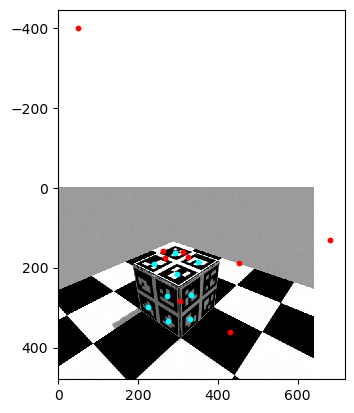

In [48]:
import cv2 as cv
import matplotlib.pyplot as plt
import tempfile
from pathlib import Path
import numpy as np
from IPython.display import display

from camera import (
    move_camera_pos,
    get_camera_image_rgb,
    get_camera_image_depth,
    draw_aruco_grid,
    extract_aruco_tags,
    draw_aruco_tags,
    map_id_to_world_coords,
    compute_dlt,
)
import rospy


rospy.init_node("camera_test")

move_camera_pos(-0.4, -0.4, 1, pitch=0.6, yaw=0.7)
rgb = get_camera_image_rgb()
frame_markers, corners, ids = extract_aruco_tags(rgb)
draw_aruco_tags(frame_markers, corners, ids)
plt.show()

ids = ids.reshape(-1)
mapping = map_id_to_world_coords(border=10, width=175, total=400, side_length=0.2)
corner_means = np.array(corners).squeeze(1).mean(axis=1)
xyz, uv = mapping[ids], corner_means

P = compute_dlt(xyz, uv)

# let's reproject the points and see if they are close to the original ones
Z = P @ np.vstack([xyz.T, np.ones(len(xyz))])
Z = (Z / Z[2]).T

display(ids, xyz, P.round(2), uv, Z.round(2))

plt.imshow(rgb)
plt.scatter(uv[:, 0], uv[:, 1], c="cyan", s=10)
plt.scatter(Z[:, 0], Z[:, 1], c="red", s=10)
plt.show()

In [59]:
np.array(corners).reshape(-1, 2)

array([[296., 192.],
       [349., 213.],
       [302., 244.],
       [248., 218.],
       [241., 170.],
       [287., 187.],
       [239., 212.],
       [194., 191.],
       [344., 166.],
       [396., 183.],
       [359., 207.],
       [306., 187.],
       [290., 148.],
       [335., 162.],
       [296., 182.],
       [252., 165.],
       [251., 296.],
       [298., 325.],
       [300., 371.],
       [256., 340.],
       [311., 324.],
       [352., 290.],
       [349., 334.],
       [312., 369.],
       [202., 266.],
       [241., 290.],
       [246., 333.],
       [210., 308.],
       [243., 229.],
       [296., 257.],
       [298., 314.],
       [250., 285.],
       [310., 255.],
       [355., 224.],
       [352., 279.],
       [311., 312.]], dtype=float32)

- https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/iet-ipr.2019.1489
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

Let's perform non-linear optimization to find the best parameters for the DLT.

$$
P = argmin_{P} \sum_{i=1}^{n} \left\| \mathbf{x}_i - \mathbf{P} \mathbf{X}_i \right\|^2
$$

To do this, we need to decompose the matrix $P$ into a set of parameters.

$$
P = K(R|T)
$$

We'll do the decomposition using QR factorization.

In [49]:
from scipy.linalg import qr

RT, K = qr(P)

# let's assert that Q and R are close to P
assert np.allclose(RT @ K, P)

K.round(2)

array([[ 3.8207e+03,  5.6728e+02,  3.1050e+02, -3.6501e+02],
       [ 0.0000e+00, -3.4140e+01, -1.7943e+02,  1.6530e+01],
       [ 0.0000e+00,  0.0000e+00,  3.4300e+00, -3.1000e-01]])

In [53]:
from scipy.optimize import least_squares
from functools import partial


def fun(rho, uv, xyz, RT, K):
    K[0, 2] = rho
    Z = (RT @ K) @ np.vstack([xyz.T, np.ones(len(xyz))])
    Z = (Z / Z[2]).T
    err = (np.linalg.norm(uv - Z[:, :2]) ** 2).sum()
    return err


res = least_squares(partial(fun, uv=uv, xyz=xyz, RT=RT, K=K), 0, method="lm")
res

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.500e+05]
           x: [-6.295e+02]
        cost: 11244142110.299831
         jac: [[ 1.194e-04]]
        grad: [ 1.791e+01]
  optimality: 17.905264129462385
 active_mask: [0]
        nfev: 22
        njev: None

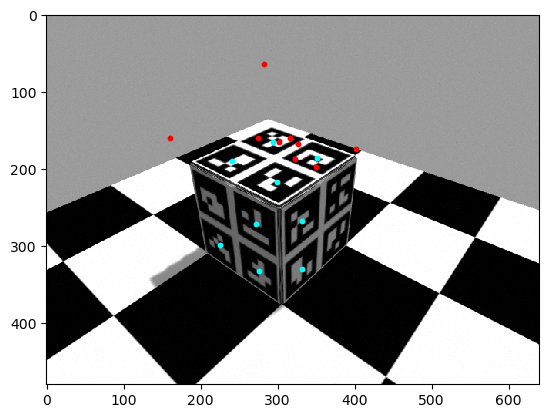

In [54]:
K = K.copy()
K[0, 2] = res.x

Z = (RT @ K) @ np.vstack([xyz.T, np.ones(len(xyz))])
Z = (Z / Z[2]).T
plt.imshow(rgb)
plt.scatter(uv[:, 0], uv[:, 1], c="cyan", s=10)
plt.scatter(Z[:, 0], Z[:, 1], c="red", s=10)
plt.show()